In [ ]:
# !pip install image_bbox_slicer

In [1]:
import sys

sys.path.append("../")

from src.constants import *

In [2]:
import image_bbox_slicer as ibs
from image_bbox_slicer.helpers import * 
from image_bbox_slicer.slicer import Points

In [3]:
im_src = f'{PATH}/data/imagenes_diagramas'
an_src = f'{PATH}/data/xml_diagramas'
im_dst = f'{PATH}/data/tiles/image_slices'
an_dst = f'{PATH}/data/tiles/xml_slices'

In [4]:
slicer = ibs.Slicer()
slicer.config_dirs(img_src=im_src, ann_src=an_src, 
                   img_dst=im_dst, ann_dst=an_dst)

slicer.keep_partial_labels = True
slicer.save_before_after_map = True

In [5]:
import glob
import os
from PIL import Image
import pandas as pd
from math import sqrt, ceil, floor
from pascal_voc_writer import Writer

In [6]:
def calc_columns_rows(n):
    """Calculates the number of columns and rows required to divide an image
    into equal parts.
    Parameters
    ----------
    n : int
        The number of equals parts an image should be split into.
    Returns
    ----------
    tuple
        Size required to divide an image into in pixels, as a 2-tuple: (columns, rows)..
    """
    num_columns = int(ceil(sqrt(n)))
    num_rows = int(ceil(n / float(num_columns)))

    return (num_columns, num_rows)

In [7]:
def __slice_images(slicer, tile_size, tile_overlap, number_tiles):
    mapper = {}
    img_no = 1

    for file in sorted(glob.glob(im_src + os.sep + "*")):
        file_name = file.split(os.sep)[-1].split('.')[0]
        file_type = file.split(os.sep)[-1].split('.')[-1].lower()

        im = Image.open(file)

        if number_tiles > 0:
            n_cols, n_rows = calc_columns_rows(number_tiles)
            tile_w, tile_h = int(
                floor(im.size[0] / n_cols)), int(floor(im.size[1] / n_rows))
            tile_size = (tile_w, tile_h)
#             tile_overlap = 0.0

        tiles = __get_tiles(im.size, tile_size, tile_overlap)
        new_ids = []
        for tile in tiles:
            new_im = im.crop(tile)
            img_id_str = str('{:06d}'.format(img_no))
            if len(slicer._ignore_tiles) != 0:
                if img_id_str in slicer._ignore_tiles:
                    slicer._ignore_tiles.remove(img_id_str)
                    continue
            new_im.save(
                '{}{}{}.{}'.format(im_dst, os.sep, img_id_str, file_type))
            new_ids.append(img_id_str)
            img_no += 1
        mapper[file_name] = new_ids

    print('Obtained {} image slices!'.format(img_no-1))
    return mapper

In [8]:
def __get_tiles(img_size, tile_size, tile_overlap):
    """Generates a list coordinates of all the tiles after validating the values.
    Private Method.
    Parameters
    ----------
    img_size : tuple
        Size of the original image in pixels, as a 2-tuple: (width, height).
    tile_size : tuple
        Size of each tile in pixels, as a 2-tuple: (width, height).
    tile_overlap: float
        Percentage of tile overlap between two consecutive strides.
    Returns
    ----------
    list
        A list of tuples.
        Each holding coordinates of possible tiles
        in the format - `(xmin, ymin, xmax, ymax)`
    """
    validate_tile_size(tile_size, img_size)
    tiles = []
    img_w, img_h = img_size
    tile_w, tile_h = tile_size
    stride_w = int((1 - tile_overlap) * tile_w)
    stride_h = int((1 - tile_overlap) * tile_h)
    
    tile_overlap = 0.6
    tmp_stride_w = int((1 - tile_overlap) * tile_w)
    tmp_stride_h = int((1 - tile_overlap) * tile_h)
        
    for y in range(0, img_h-tile_h+1, stride_h):
        
        reached_max_h = (y + tile_h + stride_h >= img_h-tile_h)
        just_started_h = (y == 0)

        if(just_started_h):
            y = 0
            y2 = y + tile_h + tmp_stride_h
        elif(reached_max_h):
            y -= tmp_stride_h
            y2 = y + tile_h + tmp_stride_h
        else:
            y += tmp_stride_h//2
            y2 = y + tile_h + tmp_stride_h//2

        for x in range(0, img_w-tile_w+1, stride_w):            
#             x2 = x + tile_w
#             y2 = y + tile_h
#             tiles.append((x, y, x2, y2))
#             print("before ", (x, y, x2, y2))

            reached_max_w = (x + tile_w + stride_w >= img_w-tile_w)

            just_started_w = (x == 0)

            if(just_started_w):
                x = 0
                x2 = x + tile_w + tmp_stride_w
            elif(reached_max_w):
                x -= tmp_stride_w
                x2 = x + tile_w + tmp_stride_w
            else:
                x += tmp_stride_w//2
                x2 = x + tile_w + tmp_stride_w//2
            
            tiles.append((x, y, x2, y2))                
    return tiles

In [9]:
def validate_tile_size(tile_size, img_size=None):
    """Validates tile size argument provided for slicing.
    Parameters
    ----------
    tile_size : tuple
        Size of each tile in pixels, as a 2-tuple: (width, height).
    img_size : tuple, optional
        Size of original image in pixels, as a 2-tuple: (width, height).
    Returns
    ----------
    None
    Raises
    ----------
    ValueError
        If `tile_size` does not hold exactly `2` values
        If `tile_size` does not comply with `img_size`
    TypeError
        If `tile_size` or `img_size` are not of type tuple.
    """
    if img_size is None:
        if isinstance(tile_size, tuple):
            if len(tile_size) != 2:
                raise ValueError(
                    'Tile size must be a tuple of size 2 i.e., (w, h). The tuple provided was {}'.format(tile_size))
        else:
            raise TypeError(
                'Tile size must be a tuple. The argument was of type {}'.format(type(tile_size)))
    else:
        if isinstance(img_size, tuple):
            if (sum(tile_size) >= sum(img_size)) or (tile_size[0] > img_size[0]) or (tile_size[1] > img_size[1]):
                raise ValueError('Tile size cannot exceed image size. Tile size was {} while image size was {}'.format(
                    tile_size, img_size))
        else:
            raise TypeError(
                'Image size must be a tuple. The argument was of type {}'.format(type(img_size)))

In [10]:
dict_images = __slice_images(tile_overlap=0.0, number_tiles=6, slicer=slicer, tile_size=None)

Obtained 462 image slices!


## Same for bboxes

In [11]:
def __slice_bboxes(slicer, tile_size, tile_overlap, number_tiles):
    img_no = 1
    mapper = {}
    empty_count = 0

    for xml_file in sorted(glob.glob(an_src + os.sep + '*.xml')):
        root, objects = extract_from_xml(xml_file)
        im_w, im_h = int(root.find('size')[0].text), int(
            root.find('size')[1].text)
        im_filename = os.path.splitext(root.find('filename').text)[0]
        extn = os.path.splitext(root.find('filename').text)[1]
        if number_tiles > 0:
            n_cols, n_rows = calc_columns_rows(number_tiles)
            tile_w = int(floor(im_w / n_cols))
            tile_h = int(floor(im_h / n_rows))
            tile_size = (tile_w, tile_h)
#             tile_overlap = 0.0
        else:
            tile_w, tile_h = tile_size
        tiles = __get_tiles((im_w, im_h), tile_size, tile_overlap)
        tile_ids = []

        for tile in tiles:
            img_no_str = '{:06d}'.format(img_no)
            voc_writer = Writer('{}{}{}{}'.format(an_dst, os.sep, img_no_str, extn), tile_w, tile_h)
            for obj in objects:
                obj_lbl = obj[-4:]
                points_info = ibs.which_points_lie(obj_lbl, tile)

                if points_info == Points.NONE:
                    empty_count += 1
                    continue

                elif points_info == Points.ALL:       # All points lie inside the tile
                    new_lbl = (obj_lbl[0] - tile[0], obj_lbl[1] - tile[1],
                               obj_lbl[2] - tile[0], obj_lbl[3] - tile[1])

                elif not slicer.keep_partial_labels:    # Ignore partial labels based on configuration
                    empty_count += 1
                    continue

                elif points_info == Points.P1:
                    new_lbl = (obj_lbl[0] - tile[0], obj_lbl[1] - tile[1],
                               tile_w, tile_h)

                elif points_info == Points.P2:
                    new_lbl = (0, obj_lbl[1] - tile[1],
                               obj_lbl[2] - tile[0], tile_h)

                elif points_info == Points.P3:
                    new_lbl = (obj_lbl[0] - tile[0], 0,
                               tile_w, obj_lbl[3] - tile[1])

                elif points_info == Points.P4:
                    new_lbl = (0, 0, obj_lbl[2] - tile[0],
                               obj_lbl[3] - tile[1])

                elif points_info == Points.P1_P2:
                    new_lbl = (obj_lbl[0] - tile[0], obj_lbl[1] - tile[1],
                               obj_lbl[2] - tile[0], tile_h)

                elif points_info == Points.P1_P3:
                    new_lbl = (obj_lbl[0] - tile[0], obj_lbl[1] - tile[1],
                               tile_w, obj_lbl[3] - tile[1])

                elif points_info == Points.P2_P4:
                    new_lbl = (0, obj_lbl[1] - tile[1],
                               obj_lbl[2] - tile[0], obj_lbl[3] - tile[1])

                elif points_info == Points.P3_P4:
                    new_lbl = (obj_lbl[0] - tile[0], 0,
                               obj_lbl[2] - tile[0], obj_lbl[3] - tile[1])

                voc_writer.addObject(obj[0], new_lbl[0], new_lbl[1], new_lbl[2], new_lbl[3],
                                     obj[1], obj[2], obj[3])
            if slicer.ignore_empty_tiles and (empty_count == len(objects)):
                slicer._ignore_tiles.append(img_no_str)
            else:
                voc_writer.save(
                    '{}{}{}.xml'.format(an_dst, os.sep, img_no_str))
                tile_ids.append(img_no_str)
                img_no += 1
            empty_count = 0
        mapper[im_filename] = tile_ids

    print('Obtained {} annotation slices!'.format(img_no-1))
    return mapper

In [12]:
dict_bboxes = __slice_bboxes(tile_overlap=0.0, number_tiles=6, slicer=slicer, tile_size=None)

Obtained 462 annotation slices!


In [13]:
mapper = pd.DataFrame.from_dict(dict_images).T
mapper.head()

,0,1,2,3,4,5
ERDiagramsMySQL-1,000001,000002,000003,000004,000005,000006
ERDiagramsMySQL-10,000007,000008,000009,000010,000011,000012
ERDiagramsMySQL-11,000013,000014,000015,000016,000017,000018
ERDiagramsMySQL-12,000019,000020,000021,000022,000023,000024
ERDiagramsMySQL-13,000025,000026,000027,000028,000029,000030


In [15]:
mapper.to_csv("../data/tiles/mapper.csv")

In [23]:
CONSTANT = 32

def draw_bbox(img, row):
    if(row['dif_x']<CONSTANT or row['dif_y']<CONSTANT):
        return cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (255,0,0), 2)
    else:
        return cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0,255,0), 2)
    

def display_all_images(df):
    for image_path in df['image_path'].unique():
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        df_image = df[df['image_path']==image_path]
        print(image_path)
        for _, row in df_image.iterrows():
            img = draw_bbox(img, row)
        display(Image.fromarray(img))

In [16]:
import pandas as pd
df = pd.read_csv("/home/nacho/TFI-Cazcarra/data/tiles/train_cardinalidades_2023.csv")
df2 = pd.read_csv("/home/nacho/TFI-Cazcarra/data/tiles/test_cardinalidades_2023.csv")

In [26]:
import cv2
from IPython.display import display
from PIL import Image

In [ ]:
display_all_images(df)

In [ ]:
display_all_images(df2)

In [17]:
df['dif_x'] = df.apply(lambda x: x['xmax']-x['xmin'], axis=1)
df['dif_y'] = df.apply(lambda x: x['ymax']-x['ymin'], axis=1)
df['dif'] = df.apply(lambda x: abs(x['dif_x']-x['dif_y']), axis=1)

In [18]:
df2['dif_x'] = df2.apply(lambda x: x['xmax']-x['xmin'], axis=1)
df2['dif_y'] = df2.apply(lambda x: x['ymax']-x['ymin'], axis=1)
df2['dif'] = df2.apply(lambda x: abs(x['dif_x']-x['dif_y']), axis=1)

In [38]:
# Hay 41 labels que no van
df[((df['dif_x']<CONSTANT) | (df['dif_y']<CONSTANT)) & (df['dif']>10)].shape

(41, 10)

In [40]:
# Estas son las que sí van
df[~(((df['dif_x']<CONSTANT) | (df['dif_y']<CONSTANT)) & (df['dif']>10))].shape

(1618, 10)

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000383.png


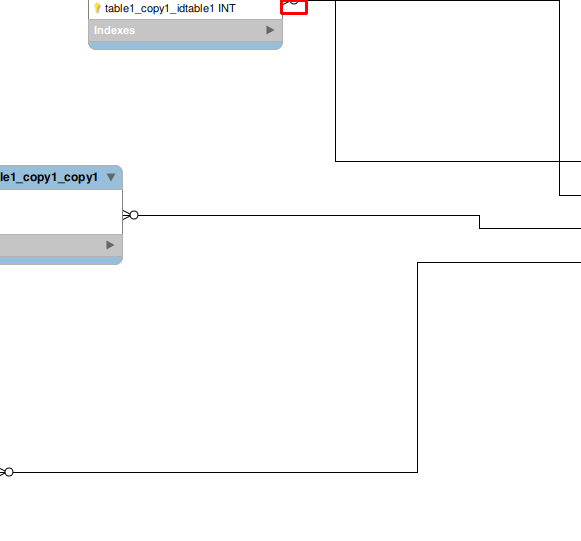

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000180.png


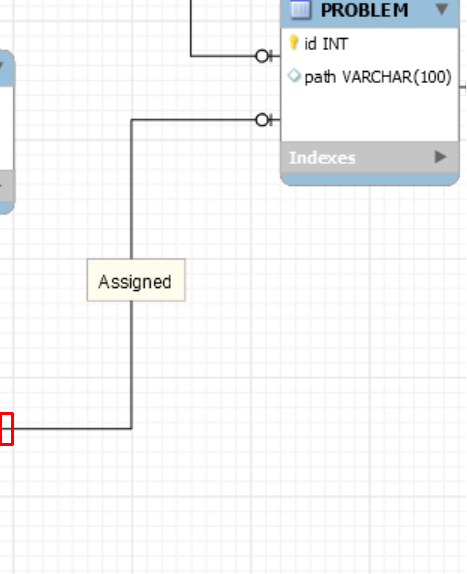

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000437.png


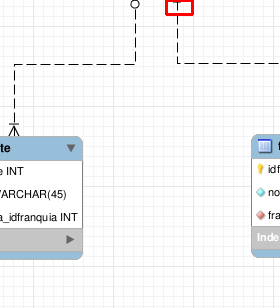

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000332.png


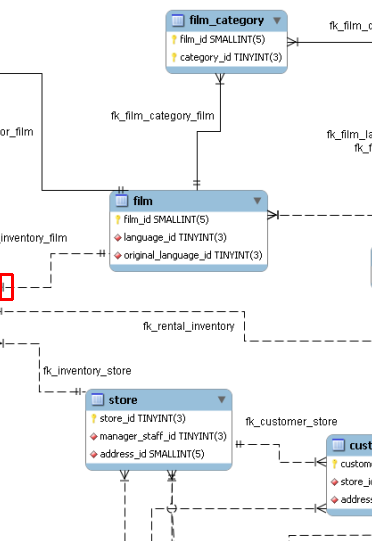

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000178.png


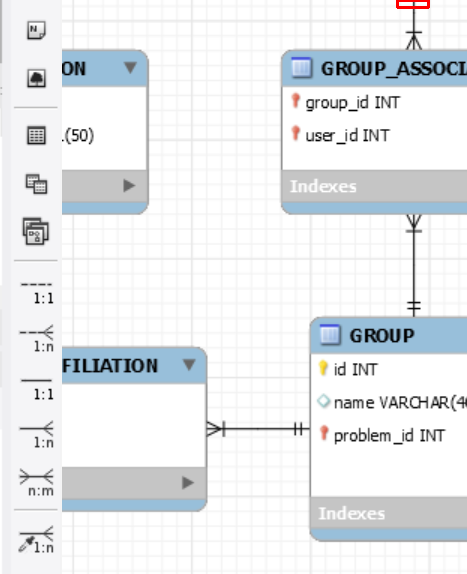

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000179.png


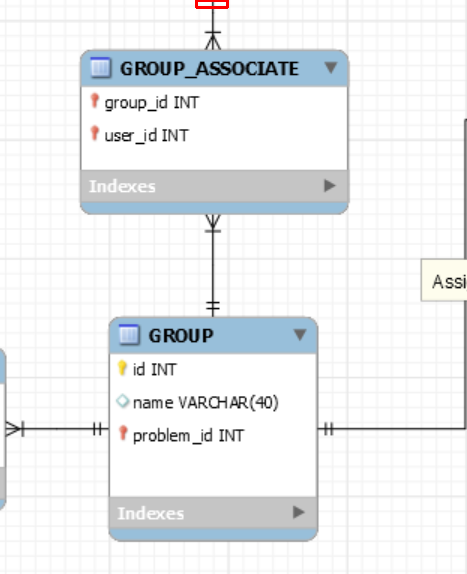

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000197.png


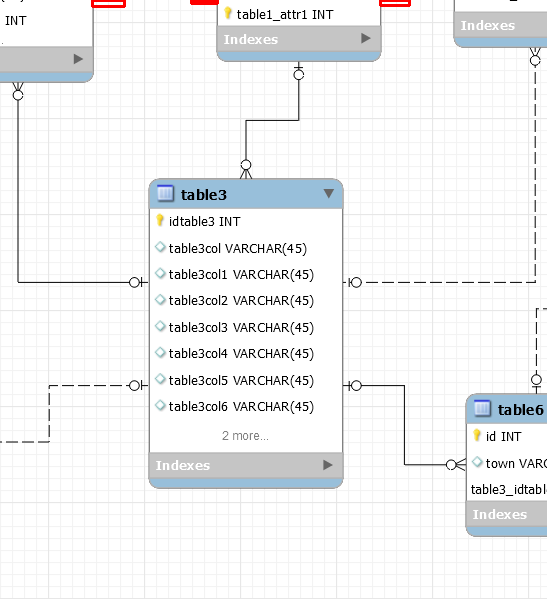

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000221.png


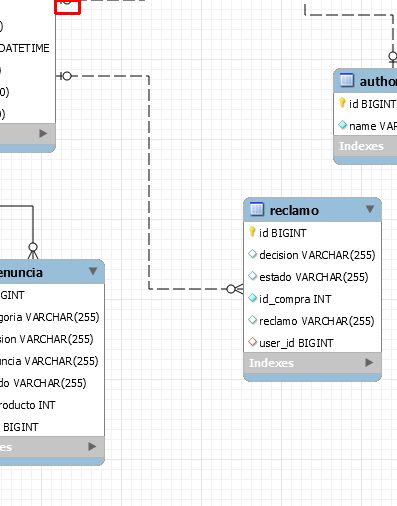

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000252.png


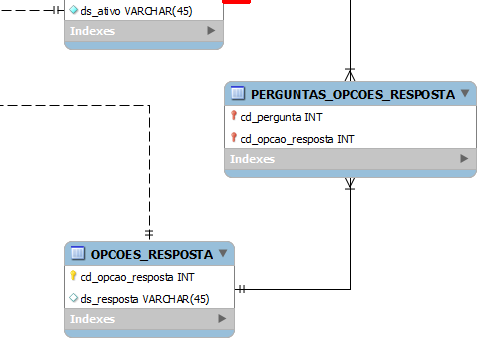

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000233.png


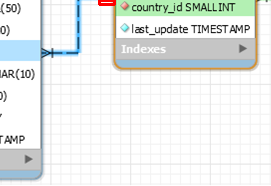

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000382.png


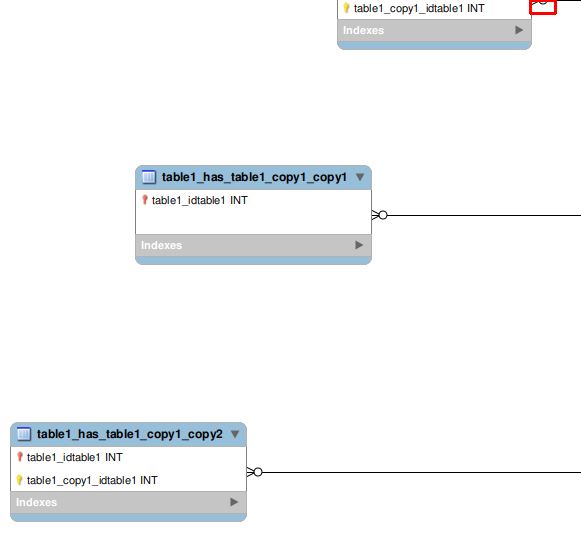

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000220.png


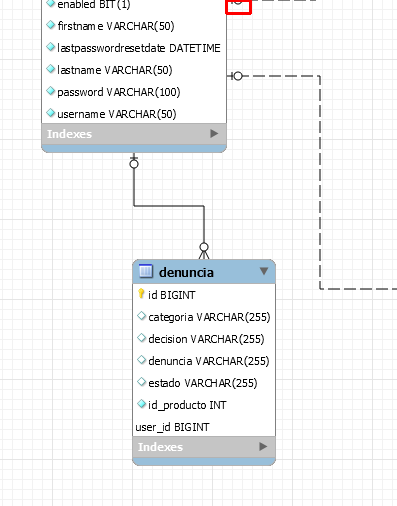

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000450.png


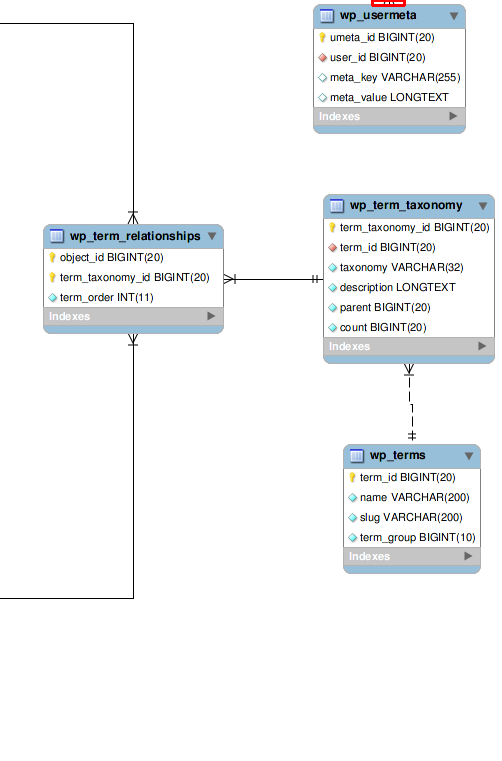

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000339.png


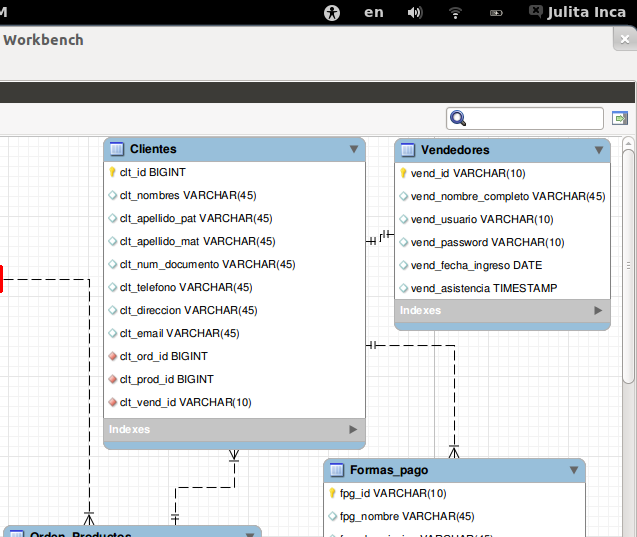

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000456.png


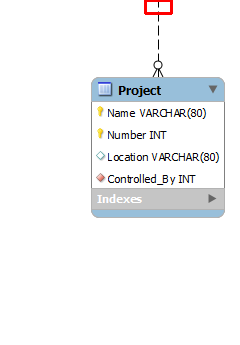

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000286.png


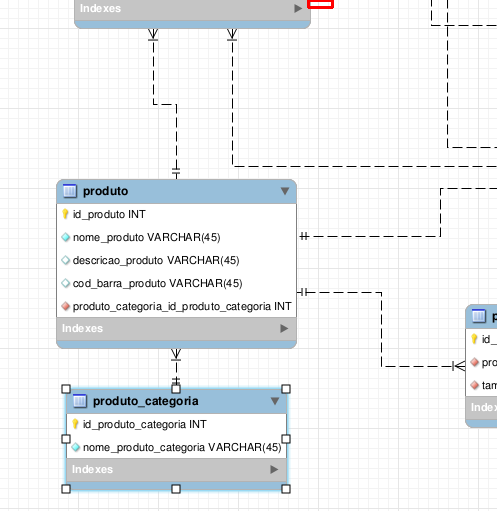

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000196.png


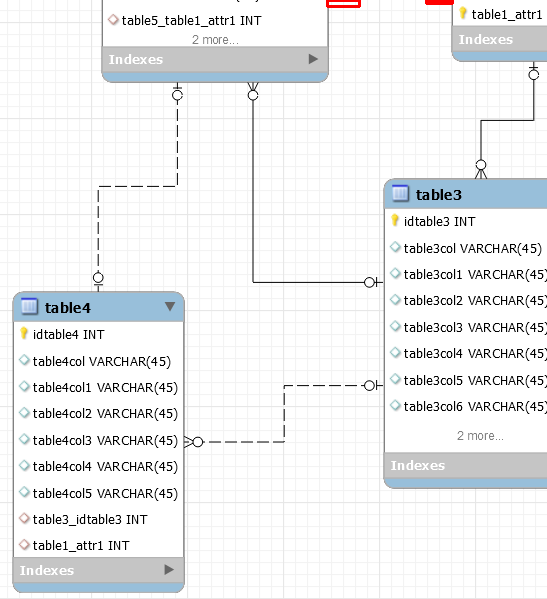

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000195.png


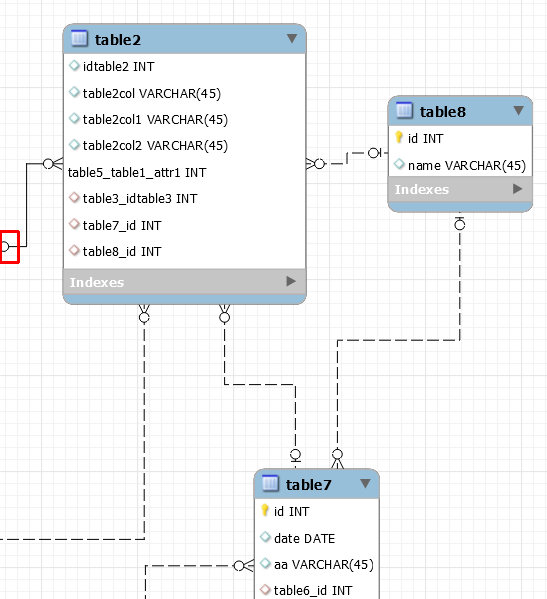

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000287.png


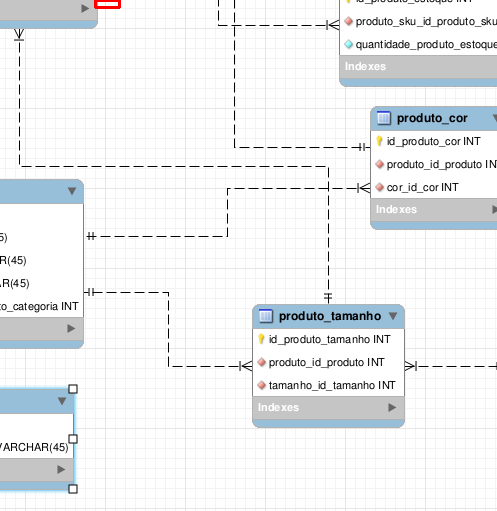

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000335.png


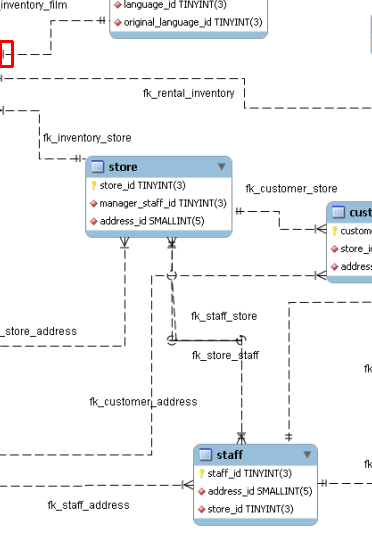

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000426.png


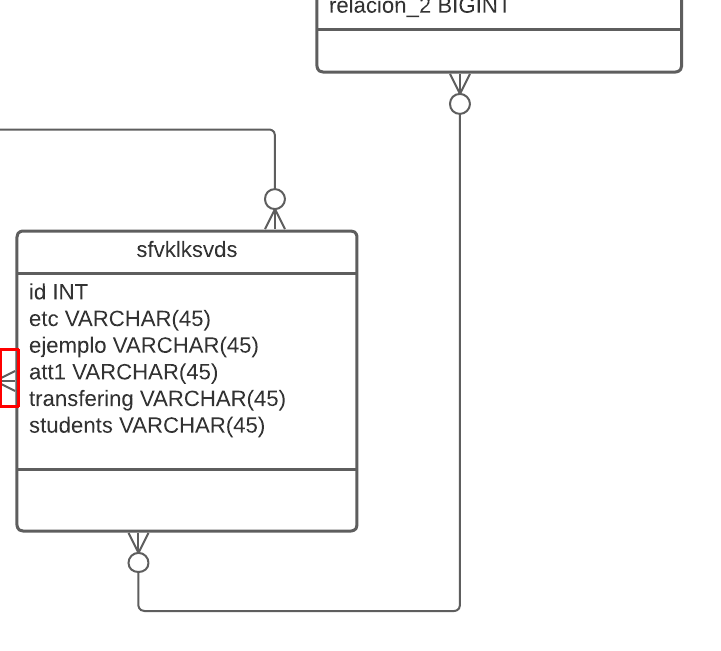

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000232.png


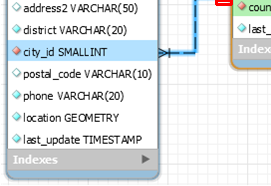

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000342.png


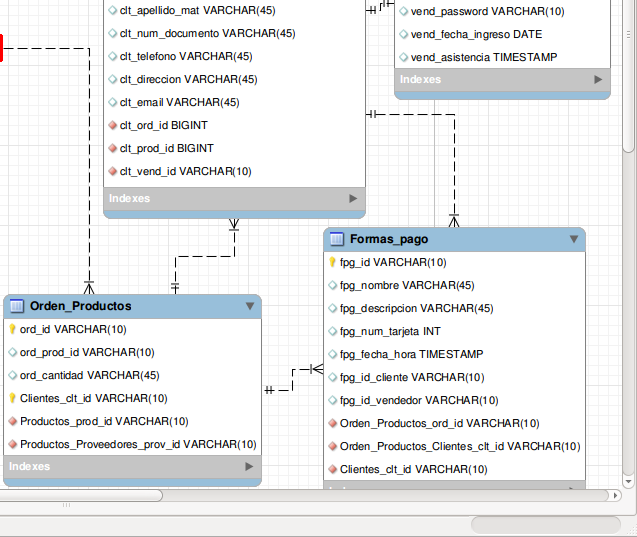

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000425.png


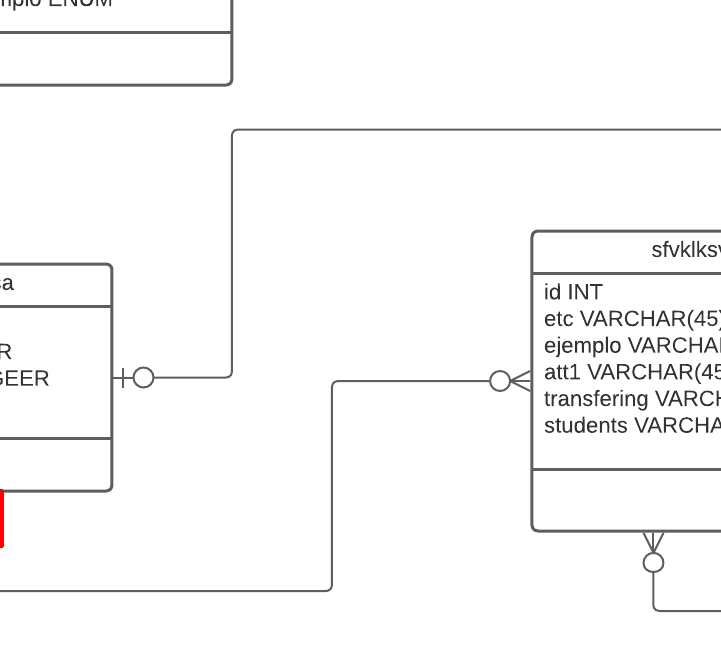

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000251.png


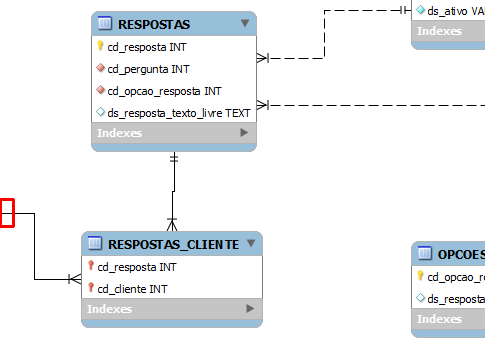

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000060.png


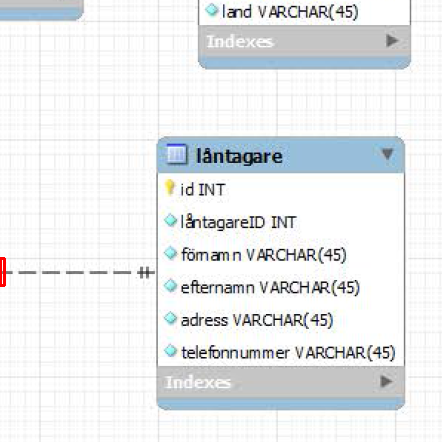

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000198.png


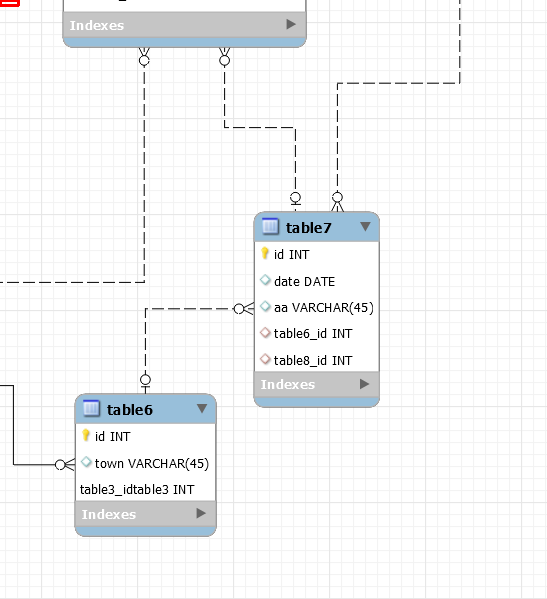

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000245.png


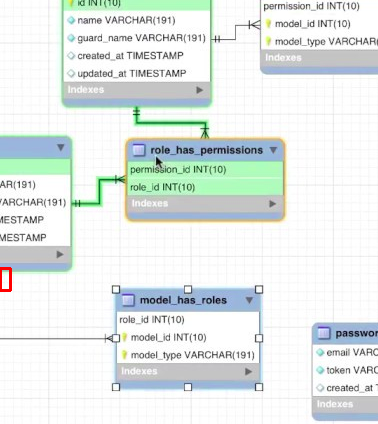

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000234.png


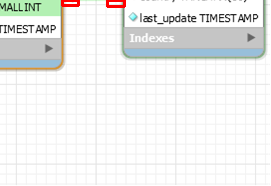

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000297.jpg


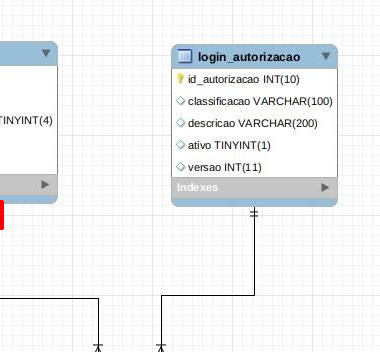

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000443.jpg


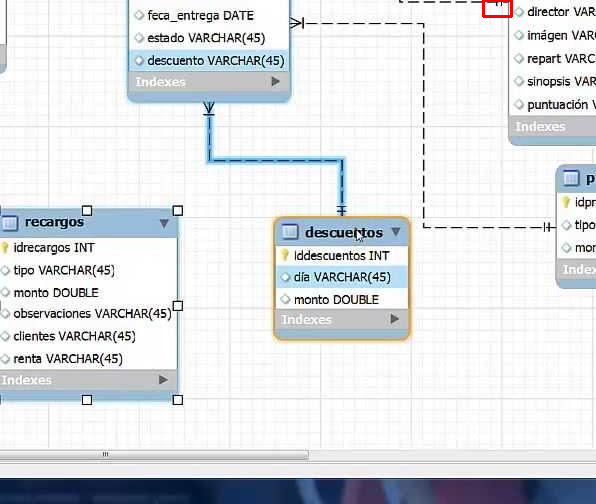

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000321.jpg


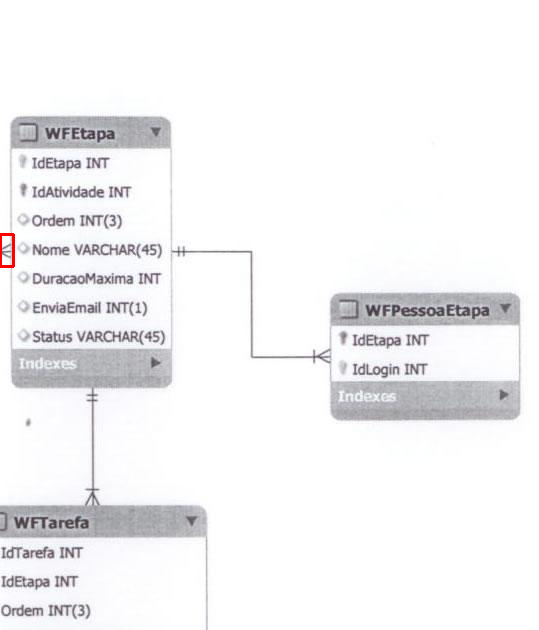

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000317.jpg


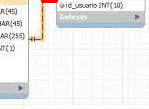

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000318.jpg


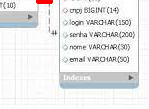

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000444.jpg


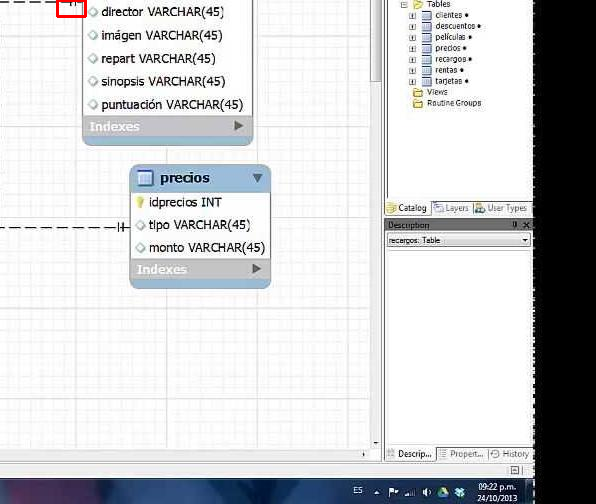

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000316.jpg


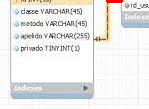

/home/nacho/TFI-Cazcarra/data/tiles/image_slices/000300.jpg


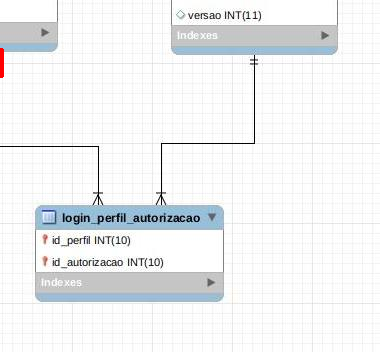

In [34]:
display_all_images(df[((df['dif_x']<CONSTANT) | (df['dif_y']<CONSTANT)) & (df['dif']>10)])

In [48]:
COLS = ['image_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label']

In [49]:
to_save_df2 = "/home/nacho/TFI-Cazcarra/data/tiles/test_cardinalidades_2023_fixed.csv"
df2[~(((df2['dif_x']<CONSTANT) | (df2['dif_y']<CONSTANT)) & (df2['dif']>10))][COLS].to_csv(to_save_df2, index=False)

In [50]:
to_save_df = "/home/nacho/TFI-Cazcarra/data/tiles/train_cardinalidades_2023_fixed.csv"
df[~(((df['dif_x']<CONSTANT) | (df['dif_y']<CONSTANT)) & (df['dif']>10))][COLS].to_csv(to_save_df, index=False)

 ## Agrando las cajas un poquitin

In [ ]:
import pandas as pd

train = pd.read_csv("/home/nacho/TFI-Cazcarra/data/tiles/train_cardinalidades_linux_fixed.csv")
test = pd.read_csv("/home/nacho/TFI-Cazcarra/data/tiles/test_cardinalidades_linux_fixed.csv")

In [ ]:
train['dif_x'] = train.apply(lambda x: x['xmax']-x['xmin'], axis=1)
train['dif_y'] = train.apply(lambda x: x['ymax']-x['ymin'], axis=1)

In [ ]:
test['dif_x'] = test.apply(lambda x: x['xmax']-x['xmin'], axis=1)
test['dif_y'] = test.apply(lambda x: x['ymax']-x['ymin'], axis=1)